## Driver code comparing output of different preproc software 
- Note: currently using output after atlas-based grouping
- Atlas used: DKT (Freesurfer) DKT-40 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import time

from sklearn.manifold import TSNE

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'code/compare-surf-tools/data/'
results_dir = proj_dir + 'data/results/'
qc_dir =  data_dir + 'QC/'

# subject demographics
demograph_file = data_dir + 'ABIDE_Phenotype.csv'

# software subdirs
ants_dir = data_dir + 'ANTs/'
civet_dir = data_dir + 'CIVET/'
fs51_dir = data_dir + 'FS5.1/'
fs53_dir = data_dir + 'FS5.3/'
fs60_dir = data_dir + 'FS6.0/'

# software CSVs
ants_file = ants_dir + 'ABIDE_ants_thickness_data.csv' 
civet_file = civet_dir + 'ABIDE_civet2.1_thickness.csv'
civet_dkt_roi_map_file = civet_dir + 'DKT/DKT_parcel_map_FS_CIVET.csv'

fs51_file = fs51_dir + 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs53_file =  fs53_dir + 'ABIDE_fs5.3_thickness.csv'
fs60_lh_file = fs60_dir + 'DKTatlas_thickness_lh.csv' #'DKTatlas_thickness_lh.csv' #'lh.aparc.thickness.table.test1' 
fs60_rh_file = fs60_dir + 'DKTatlas_thickness_rh.csv' #'DKTatlas_thickness_rh.csv' #'rh.aparc.thickness.table.test1'

#software_roi_map = '/DKT/Software_ROI_map.csv' # TODO: Need to use this instead parising names everytime.

# QC/outlier files
manual_outlier_file = qc_dir + 'manual/master_QC_table.csv'
software_outlier_file = qc_dir + 'auto/software/software_outlier_data.csv'

### Workflow configs

In [3]:
software_list = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0']
covar_list = ['SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']
qc_list = ['No_QC','manual_lenient','manual_stringent','auto']

# pipeline parameter label along which the variation is assessed
data_label = 'software'

### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Load data

In [5]:
# Demographics and Dx
demograph = pd.read_csv(demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

print('loading available datasets...\n')

data_dict = {}
for software in software_list:
    # CIVET 2.1
    if software == 'CIVET':
        civet_data = pd.read_csv(civet_file, dtype={subject_ID_col: str})
        print('shape of civet data {}'.format(civet_data.shape))
        # ROI names to match FS and CIVET parcels
        civet_dkt_roi_map = pd.read_csv(civet_dkt_roi_map_file)
        data_std = standardize_civet_data(civet_data, subject_ID_col, civet_dkt_roi_map)

    # ANTs
    if software == 'ANTs':
        ants_data = pd.read_csv(ants_file, header=2)
        print('shape of ants data {}'.format(ants_data.shape))
        data_std = standardize_ants_data(ants_data, subject_ID_col)

    # FS    
    if software == 'FS5.1':
        fs51_data = pd.read_csv(fs51_file)
        print('shape of fs51 data {}'.format(fs51_data.shape))
        data_std = standardize_fs_data(fs51_data, subject_ID_col)
        
    if software == 'FS5.3':
        fs53_data = pd.read_csv(fs53_file)
        print('shape of fs53 data {}'.format(fs53_data.shape))
        data_std = standardize_fs_data(fs53_data, subject_ID_col)

    if software == 'FS6.0':
        fs60_lh_data = pd.read_csv(fs60_lh_file, delim_whitespace=True)
        fs60_rh_data = pd.read_csv(fs60_rh_file, delim_whitespace=True)
        print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))        
        data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col,aparc='aparc.DKTatlas')
    
    print('  shape of stdized {} data {}\n'.format(software, data_std.shape))
    data_dict[software] = data_std

loading available datasets...

shape of ants data (1101, 99)
  shape of stdized ANTs data (1101, 90)

shape of civet data (899, 65)
  shape of stdized CIVET data (899, 65)

shape of fs51 data (1112, 74)
  shape of stdized FS5.1 data (1112, 74)

shape of fs53 data (976, 74)
  shape of stdized FS5.3 data (976, 74)

shape of fs60 data l: (1047, 33), r: (1047, 34)
shape of left and right merge fs6.0 df (1047, 66)
  shape of stdized FS6.0 data (1047, 66)



### Create master dataframe

In [6]:
na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 

master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action, data_label)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col] + covar_list].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls) 
# Replace to (2 with 0 for statsmodels to define 1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}, ROIs {}'.format(len(common_subs), 
                                                       master_df_raw[master_df_raw[data_label]=='fs60']['DX_GROUP'].value_counts().to_dict(),
                                                       len(common_roi_cols)))


Number of datasets: 5
Finding common subject and columns
dataset : ANTs
common subs: 1101
dataset : CIVET
common subs: 898
dataset : FS5.1
common subs: 898
dataset : FS5.3
common subs: 800
dataset : FS6.0
common subs: 778
Number of common subjects and columns: 778, 63

checking ANTs dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (778, 64)

checking CIVET dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (1556, 64)

checking FS5.1 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (2334, 64)

checking FS5.3 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (3112, 64)

checking FS6.0 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shap

### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 
- Ringing subs: ['0050197',0050211','0050049','0051160','0050815','0050418','0050422','0050423','0050309','0050283','0050313','0050323','0051353','0051352','0051334']

In [7]:
# Dictionary allow iterating and QC comparisons later
# Default master_df is without QC

master_df_dict = {}
n_workflow = len(master_df_raw[data_label].unique())
outlier_df = pd.DataFrame(index=master_df_raw[subject_ID_col].unique())
for qc in qc_list:
    if qc == 'No_QC':
        print('No QC applied')
        filtered_df = master_df_raw
        filtered_subs = filtered_df[subject_ID_col].unique()
        print('Resultant number of subjects {}'.format(len(filtered_subs)))
    else:            
        if qc == 'manual_lenient':
            qc_df = pd.read_csv(manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_maarten',[0]) # keep subs
        elif qc == 'manual_stringent':
            qc_df = pd.read_csv(manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
        elif qc == 'auto':
            qc_df_long = pd.read_csv(software_outlier_file ,dtype={'SubjID': int})
            qc_df = qc_df_long.pivot(index=subject_ID_col,columns='pipeline',values='outlier_ind')
            qc_df.apply(pd.to_numeric)
            #keep only if a subject is not an outlier in any of the software
            qc_df['QC_outlier'] = qc_df[list(qc_df.columns)].sum(axis=1) 
            qc_df[subject_ID_col] = qc_df.index
            qc_criterion = ('QC_outlier',[0])    
        else:
            print('Unknow QC type')

        # Subjects you want to keep based on other crieria for sample size purposes
        external_criterion = {'SITE_ID':3*n_workflow}
        filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
        filtered_subs = filtered_df[subject_ID_col].unique()
        outlier_df[qc] = np.where(outlier_df.index.isin(filtered_subs),0,1)
        
    master_df_dict[qc] = filtered_df

master_df = master_df_dict['No_QC'] # Default

No QC applied
Resultant number of subjects 778

Filtering based on QC_maarten. Number subjects before filtering 778
Resultant number of subjects 748
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects 748

Filtering based on QC_gleb. Number subjects before filtering 778
Resultant number of subjects 204
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID UCLA_2     15
OLIN       15
MAX_MUN    15
PITT        5
Name: SITE_ID, dtype: int64
Resultant number of subjects 194

Filtering based on QC_outlier. Number subjects before filtering 778
Resultant number of subjects 685
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workf

### Basic demographic distributions


QC type: No_QC
Number of subjects 778

QC type: manual_lenient
Number of subjects 748

QC type: manual_stringent
Number of subjects 194

QC type: auto
Number of subjects 683


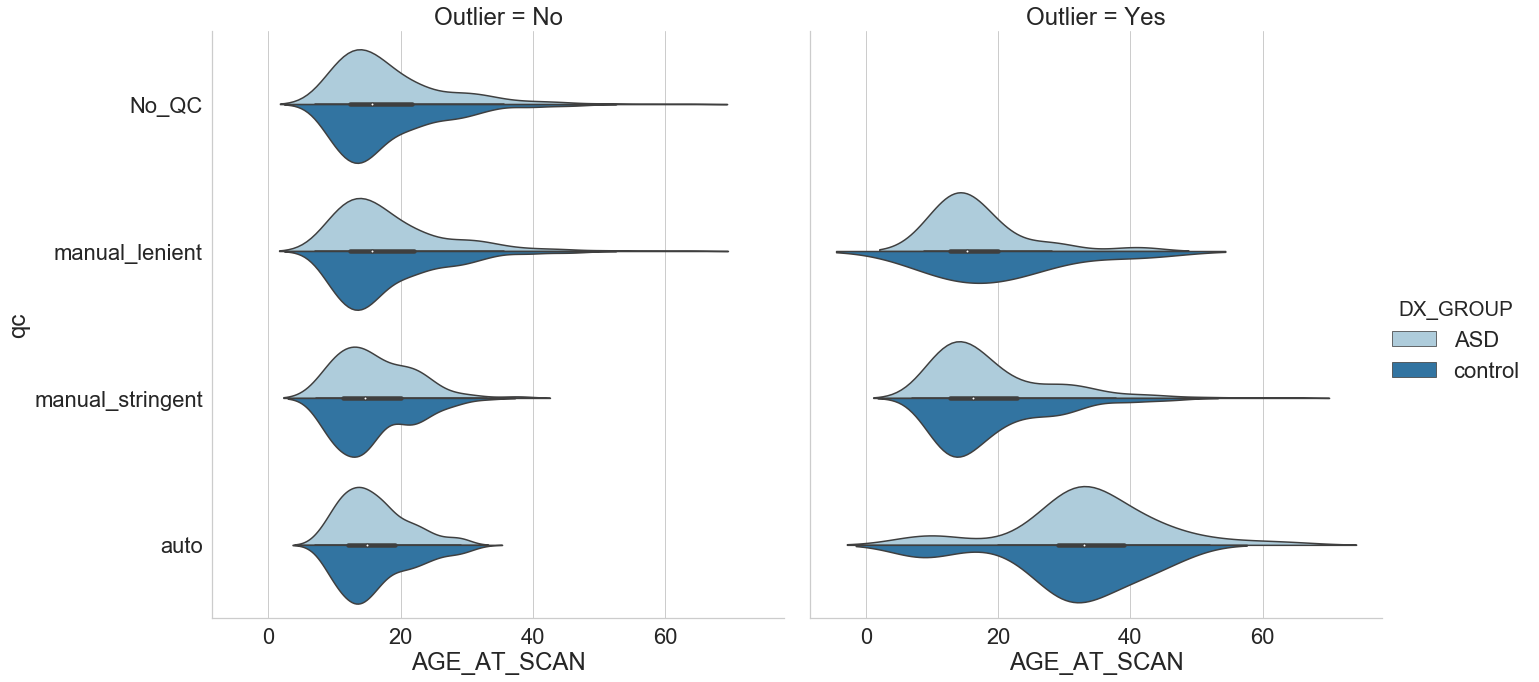

In [11]:
demo_df_concat = pd.DataFrame()

for qc in qc_list:
    demo_dist_df = master_df_raw[master_df_raw[data_label]=='CIVET'][[subject_ID_col]+covar_list].copy()
    demo_dist_df['Outlier'] = np.tile('Yes',len(demo_dist_df))
    
    print('\nQC type: {}'.format(qc))
    master_df_long = master_df_dict[qc]
    master_df = master_df_long[master_df_long[data_label]=='CIVET']
    print('Number of subjects {}'.format(len(master_df)))
    filtered_subs = master_df[subject_ID_col].unique()
    
    demo_dist_df.loc[demo_dist_df[subject_ID_col].isin(filtered_subs),'Outlier'] = 'No'
    demo_dist_df['qc'] = np.tile(qc,len(demo_dist_df))
    demo_df_concat = demo_df_concat.append(demo_dist_df[covar_list+['qc','Outlier']])
    
plot_df = demo_df_concat
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
plot_df['SEX'] = plot_df['SEX'].replace({0:'M', 1:'F'})

sns.set(font_scale=2)
palette="Paired"
with sns.axes_style("whitegrid"):
    sns.catplot(x="AGE_AT_SCAN", y="qc", hue="DX_GROUP", kind="violin", split=True, height=10, aspect=1,
                col='Outlier', palette=palette, data=plot_df,sharey=True);

Total number of subjects: 778

outlier overlap
                  manual_lenient  manual_stringent  auto
manual_lenient                30                30     6
manual_stringent              30               584    89
auto                           6                89    95


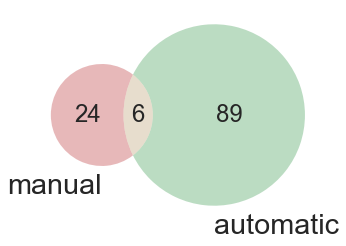

In [12]:
# Outlier comparisons
outlier_overlap = outlier_df.T.dot(outlier_df)
print('Total number of subjects: {}\n'.format(len(outlier_df)))
print('outlier overlap')
print(outlier_overlap)

# Venn diagrams
s1 = set(outlier_df[outlier_df['manual_lenient']==1].index)
s2 = set(outlier_df[outlier_df['manual_stringent']==1].index)
s3 = set(outlier_df[outlier_df['auto']==1].index)
v = venn2([s1,s3],set_labels = ('manual', 'automatic'))
#v = venn3([s1,s2,s3],set_labels = ('manual_maarten', 'manual_gleb', 'auto'))


### Correlation between software tools

In [13]:
master_df = master_df_dict['auto']

possible_pairs = list(itertools.combinations(data_dict.keys(), 2))
xcorr_pairs_df = pd.DataFrame()
table_df = pd.DataFrame(columns=software_list,index=software_list)
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    for dx in [0,1]:
        df1 = master_df[(master_df[data_label]==pipe1)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        df2 = master_df[(master_df[data_label]==pipe2)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        xcorr_df = cross_correlations(df1,df2,subject_ID_col)
        xcorr_df['{}_pair'.format(data_label)] = np.tile(str('{}-{}'.format(pair[0],pair[1])),len(xcorr_df))
        xcorr_df['DX_GROUP'] = np.tile(dx,len(xcorr_df))
        xcorr_pairs_df = xcorr_pairs_df.append(xcorr_df)
        mean_corr = np.mean(xcorr_df['correlation'].values)
        #print('DX {}, Avg cross correlation between {} & {} = {:4.2f}\n'.format(dx, pipe1,pipe2,mean_corr))
        table_df.loc[pipe1,pipe2] = mean_corr.round(2)
        table_df.loc[pipe2,pipe1] = mean_corr.round(2)

print('Correlation between software tools')
table_df

Correlation between software tools


,ANTs,CIVET,FS5.1,FS5.3,FS6.0
ANTs,NaN,0.39,0.39,0.46,0.41
CIVET,0.39,NaN,0.44,0.48,0.49
FS5.1,0.39,0.44,NaN,0.87,0.83
FS5.3,0.46,0.48,0.87,NaN,0.88
FS6.0,0.41,0.49,0.83,0.88,NaN


Shape of cross-corr df (1240, 4), number of pairs 10


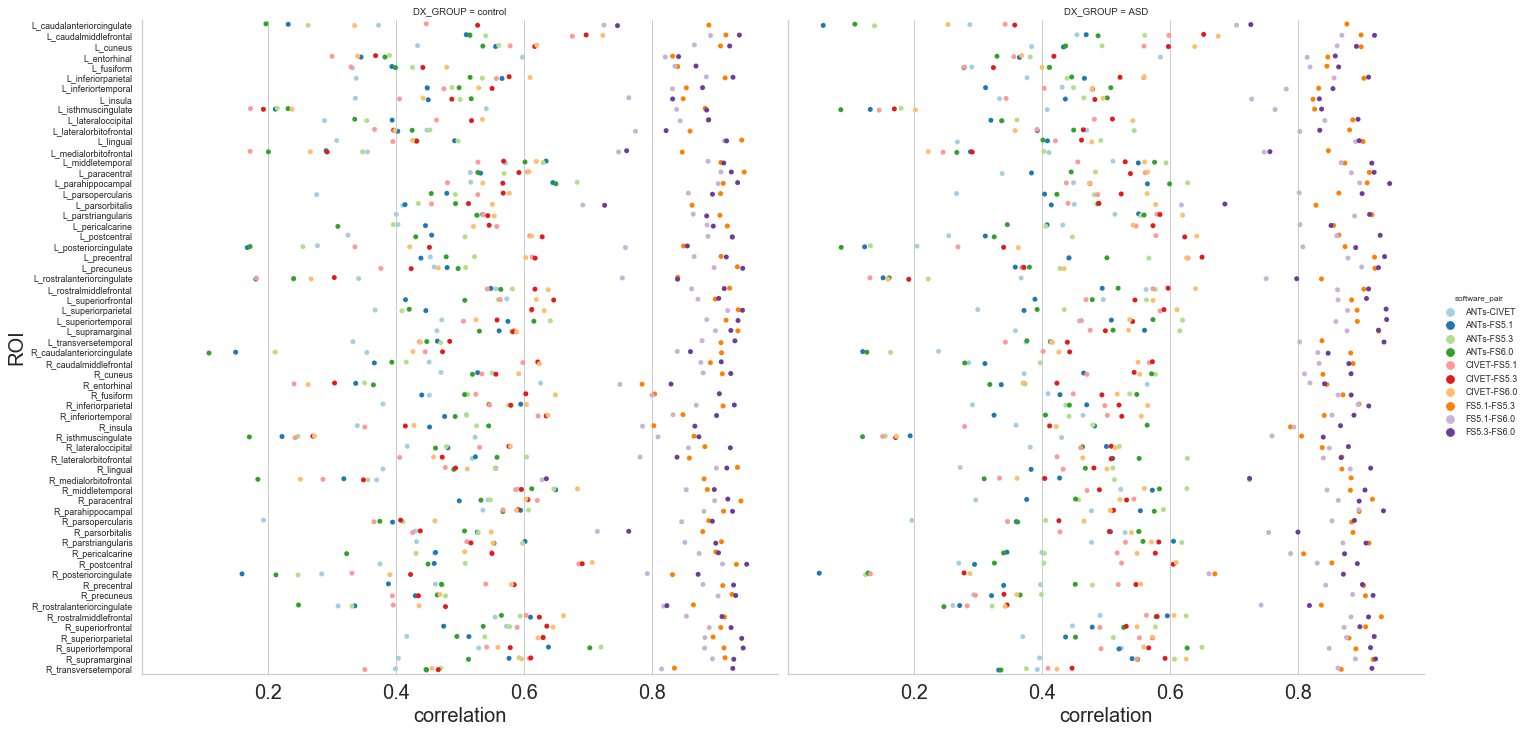

In [11]:
# Plot ROI wise correlations

plot_df = xcorr_pairs_df
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})

print('Shape of cross-corr df {}, number of pairs {}'.format(xcorr_pairs_df.shape, 
                                                             len(xcorr_pairs_df['{}_pair'.format(data_label)].unique())))
roi_order = sorted(list(xcorr_pairs_df['ROI'].unique()))
sns.set(font_scale=0.8)
palette = 'Paired'
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='{}_pair'.format(data_label),col='DX_GROUP',
                    palette=palette,aspect=1,height=10,kind='strip',order=roi_order,
                    data=plot_df)
    g.set_xticklabels(fontsize=20)
    g.set_xlabels(fontsize=20)
    g.set_ylabels(fontsize=20)
    g.set_titles(fontsize=40)

### Covariance / Correlation between ROIs

Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (778, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (748, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (194, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)
Shapes df (683, 63), df_corr (62, 62)


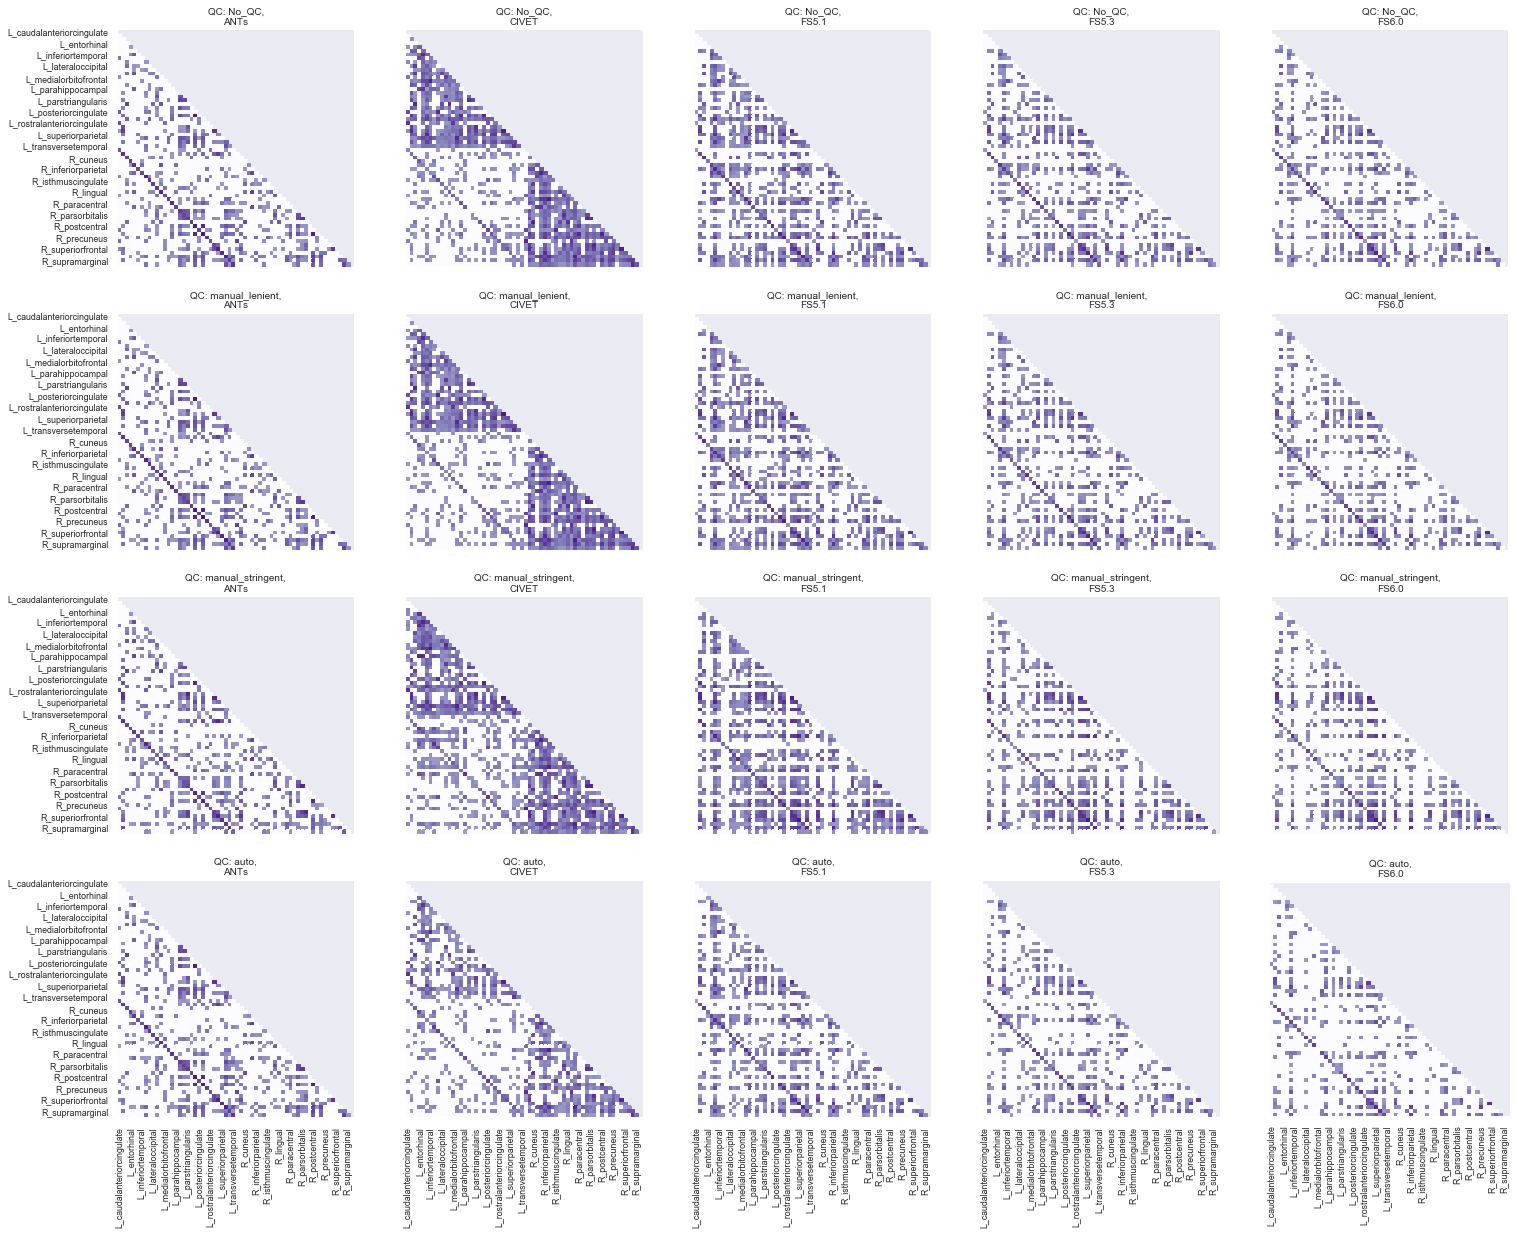

In [12]:
p_thresh= 0.05/(62*62/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

fig,axn = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(25, 20))
# Generate a custom diverging colormap
palette = 'Purples'#sns.xkcd_palette(["very light pink",'pinkish']) 
       
p=0
for qc in qc_list:
    master_df = master_df_dict[qc]

    for pipe in software_list:
        df = master_df[master_df[data_label]==pipe][[subject_ID_col]+common_roi_cols].copy()
        df_sorted = df.sort_index(1)
        #df_sorted = df.reindex(sorted(df.columns), axis=1)

        corr = df_sorted.corr()
        df_p_val = calculate_pvalues(df_sorted)
        corr[df_p_val >= p_thresh] = 0
        corr[corr < r_thresh] = 0
        print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

        # Plot
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

        
        with sns.axes_style("whitegrid"):
            sns.set(font_scale=0.5)
            g = sns.heatmap(corr, mask=mask, square=True, cmap=palette, ax=axn.flat[p],cbar=False)
            g.set_title('QC: {},\n{}'.format(qc,pipe),fontsize=10)
#             colorbar = g.collections[0].colorbar
#             colorbar.set_ticks([0.25,0.75])
#             colorbar.set_ticklabels(['0', '1'])
#             g.figure.axes[-1].tick_params(labelsize=20)
    
        p+=1

### Covariance / Correlation between Individuals

Shapes df (683, 63), df_corr (683, 683)


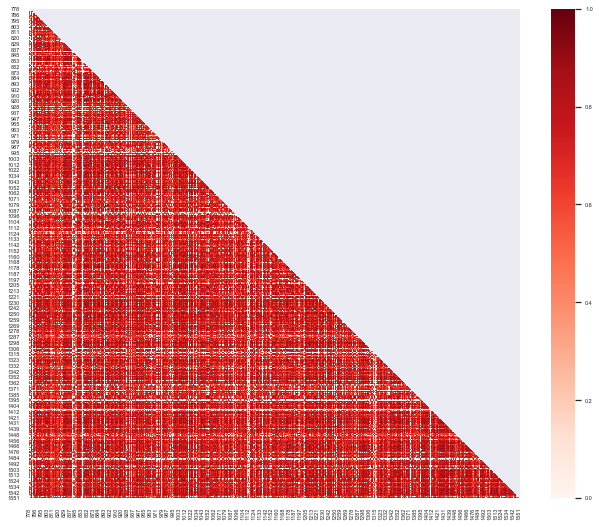

In [15]:
p_thresh= 0.05/(778*778/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

pipe = 'CIVET'
df = master_df[master_df[data_label]==pipe][[subject_ID_col]+common_roi_cols]
df_sorted = df.reindex(sorted(df.columns), axis=1)

corr = df_sorted[common_roi_cols].transpose().corr()
df_p_val = calculate_pvalues(df_sorted)
corr[df_p_val >= p_thresh] = 0
corr[corr < r_thresh] = 0
print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

# Plot
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'Reds'#sns.diverging_palette(220, 10, as_cmap=True)


with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True)


### TSNE

In [24]:
qc = 'auto'
master_df = master_df_dict[qc]

X = master_df[common_roi_cols].values
print(master_df.shape)

X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(3415, 68)


(3415, 2)

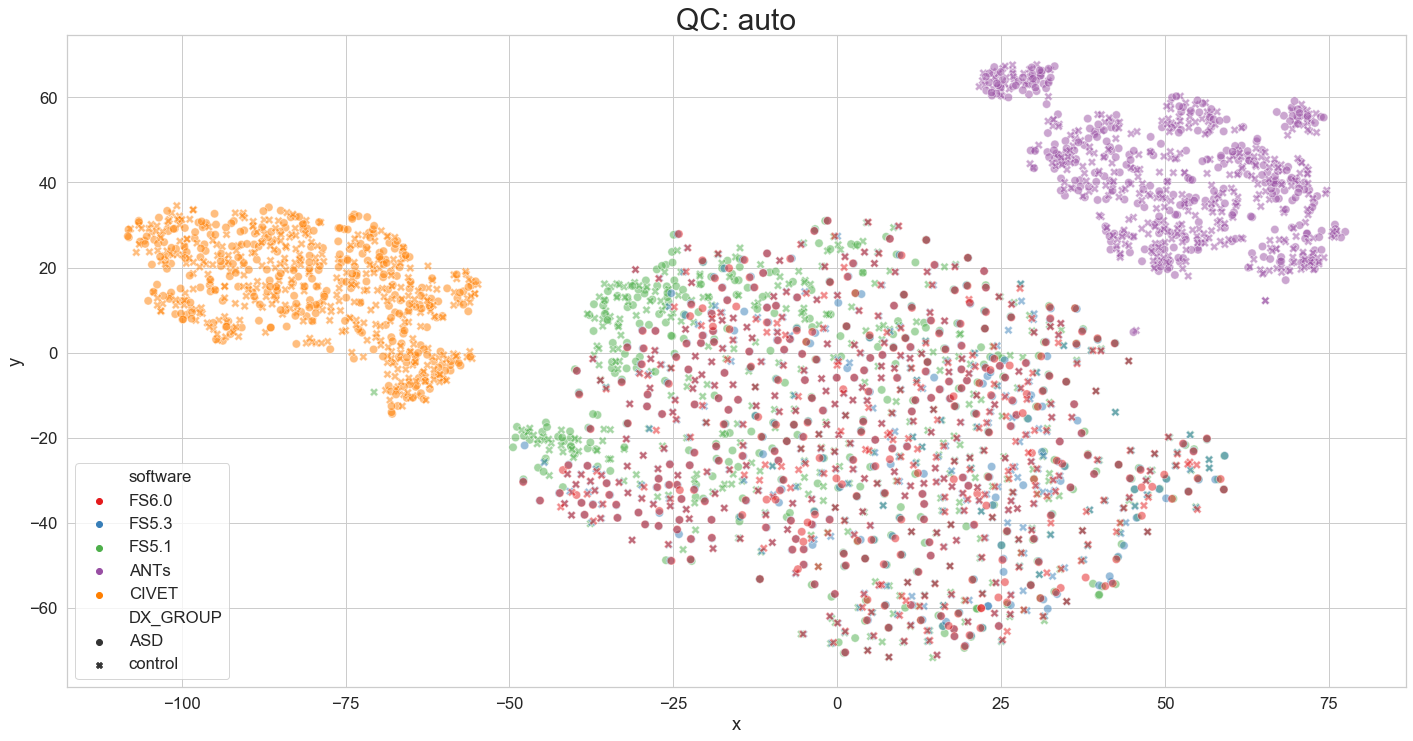

In [25]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df[data_label] = master_df[data_label].values
embed_df['DX_GROUP'] = master_df['DX_GROUP'].values
embed_df['DX_GROUP'] = embed_df['DX_GROUP'].replace({0:'control', 1:'ASD'})

plt.figure(figsize=(24,12))
sns.set(font_scale=1.52) 
hue_order = ['FS6.0','FS5.3','FS5.1','ANTs','CIVET']
with sns.axes_style("whitegrid"):
    g = sns.scatterplot(x='x',y='y',hue=data_label,hue_order=hue_order, style='DX_GROUP', s=70, alpha=0.5,
                    data=embed_df,palette="Set1")
    g.legend(loc=3)
    plt.title('QC: {}'.format(qc),fontsize=30)
    #g.figure.savefig('/Users/nikhil/Desktop/tsne.png', dpi=300)

### Subject clustering

software: ANTs
software: CIVET
software: FS5.1
software: FS5.3
software: FS6.0


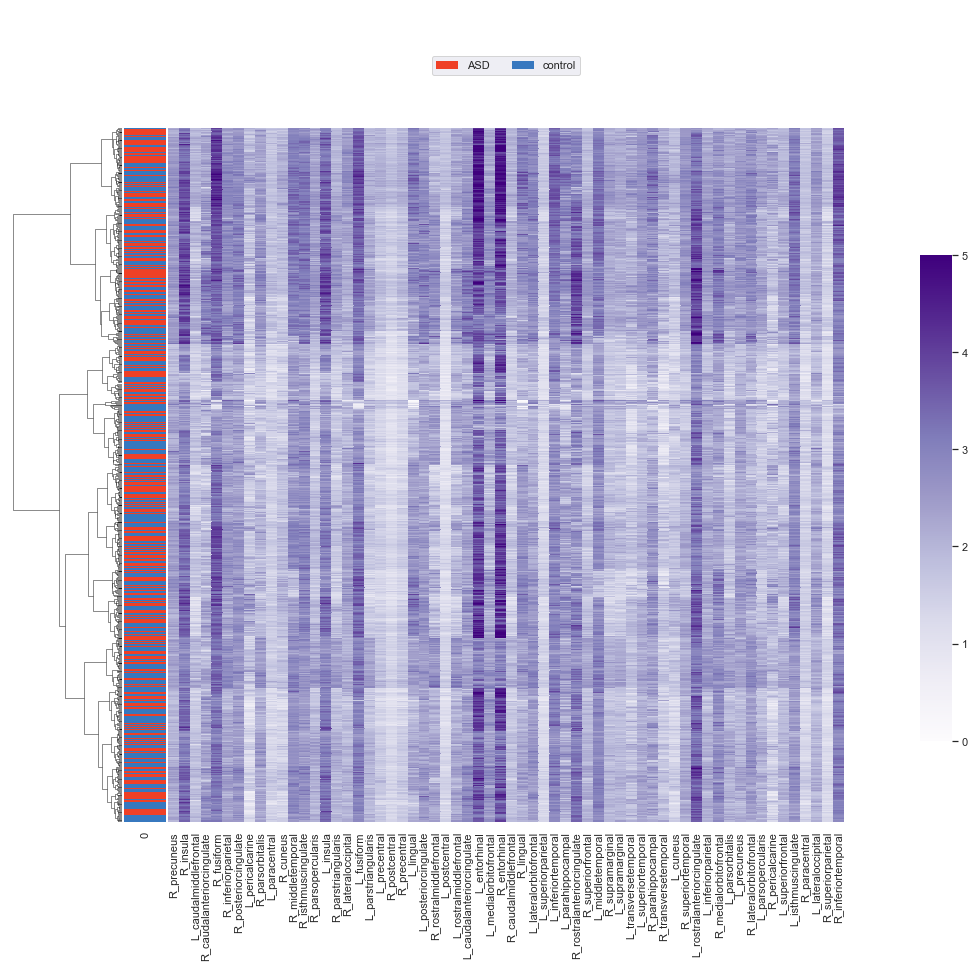

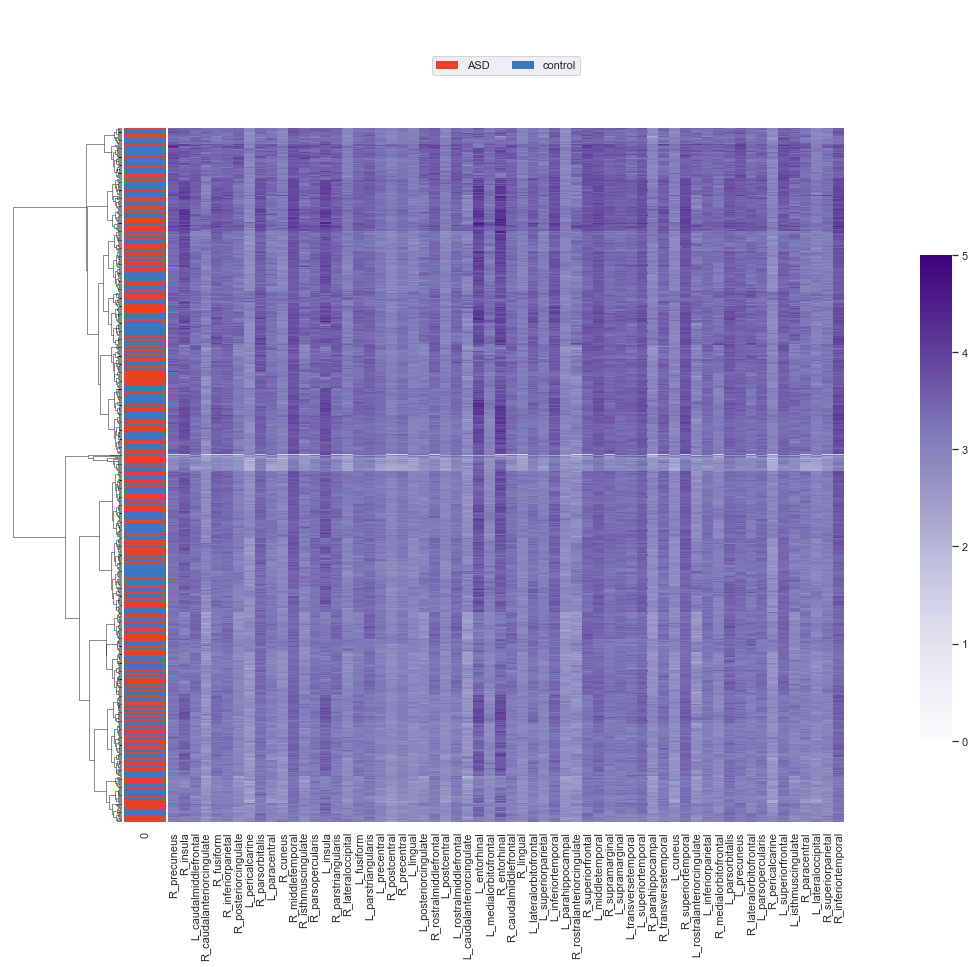

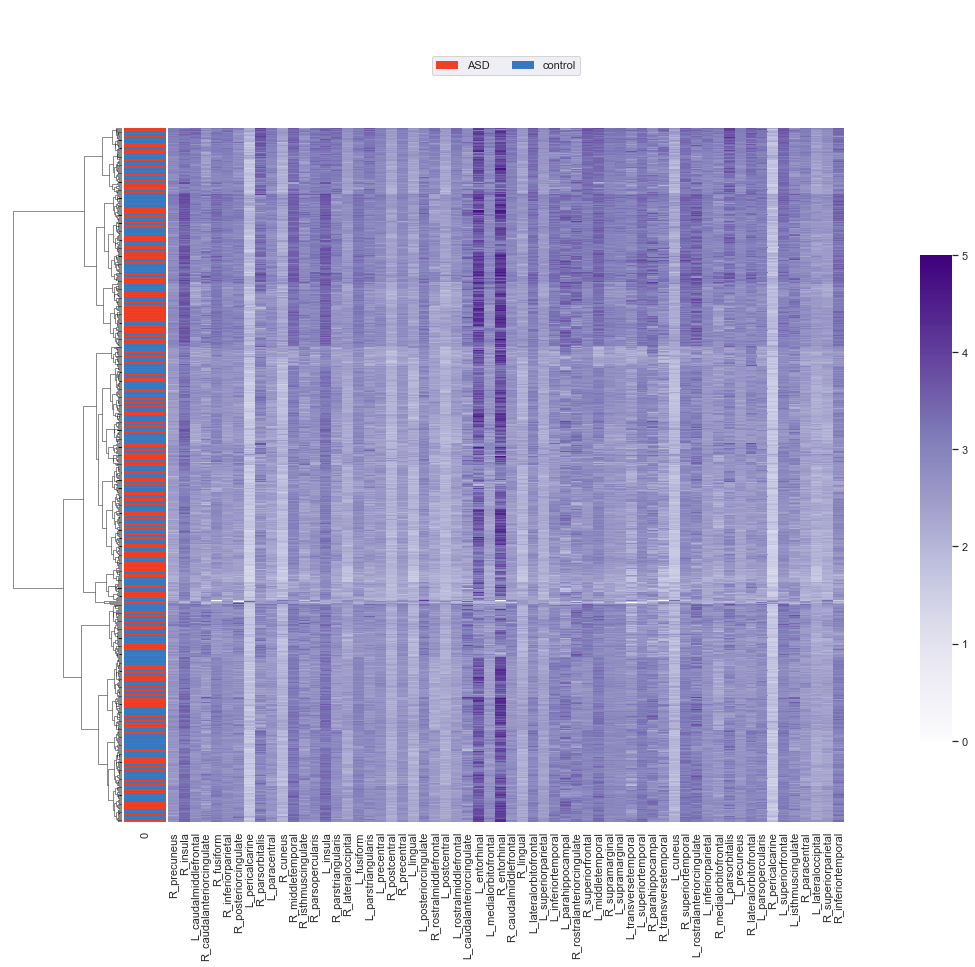

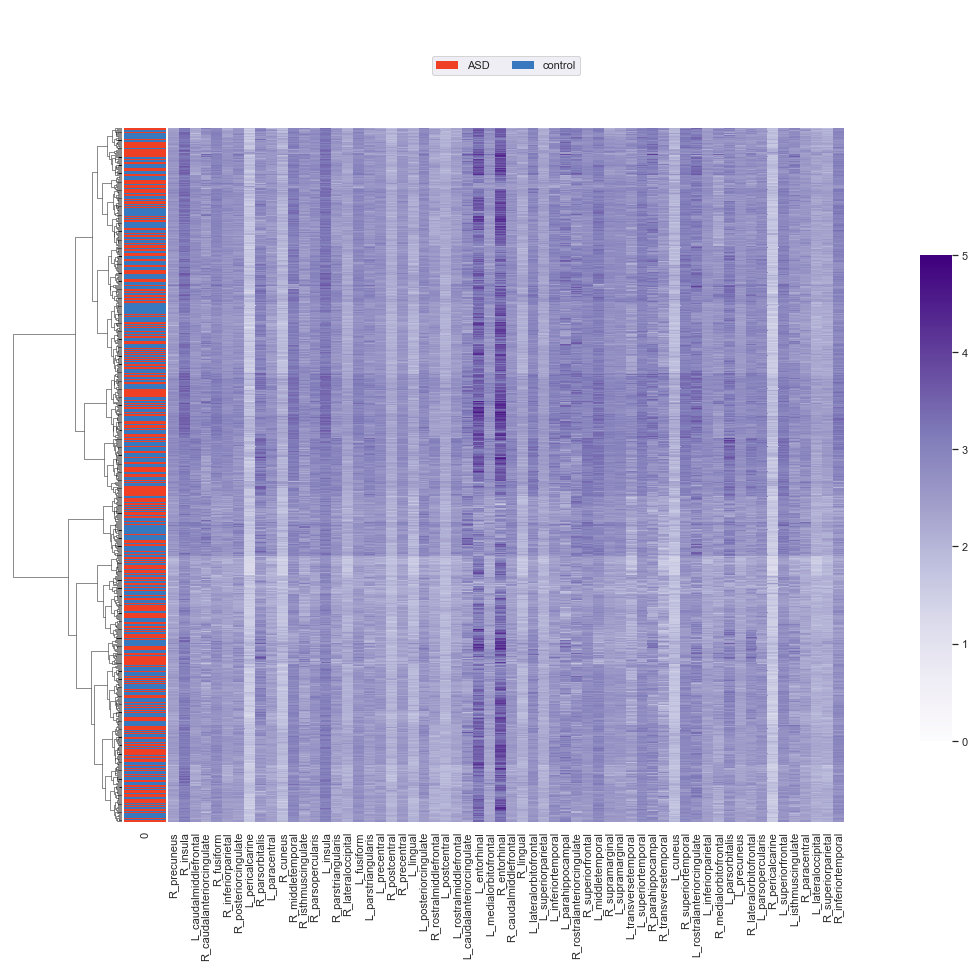

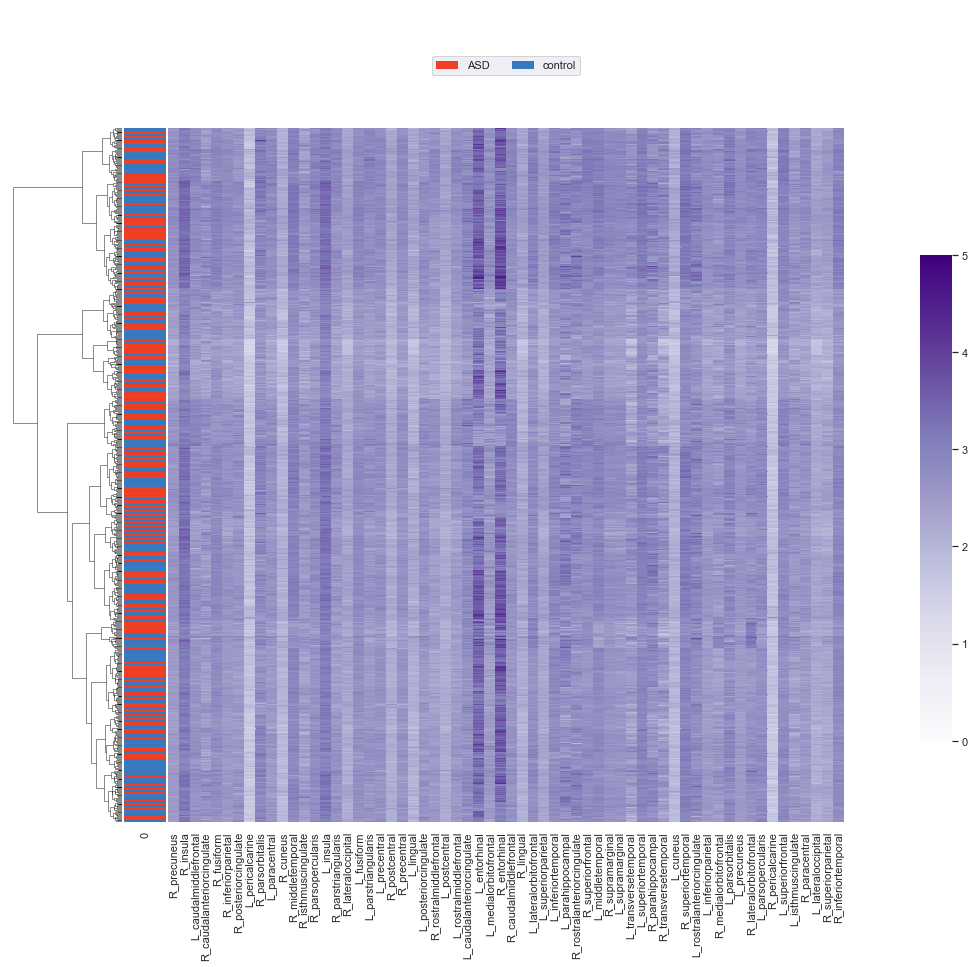

In [15]:
qc = 'No_QC'
master_df = master_df_dict[qc]

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# colors for the Dx visuals
colors = ["tomato","windows blue"]
Dx_palette = sns.xkcd_palette(colors)

sns.set(style="white")
sns.set(font_scale=1)

# Generate a custom diverging colormap
cmap = 'Purples' #sns.cubehelix_palette()#sns.diverging_palette(220, 10, as_cmap=True)

# create clustermap list for calculating overlap later
clustermap_dict = {} 

for pipe in master_df[data_label].unique():
    print('software: {}'.format(pipe))
    cluster_df = master_df[master_df[data_label]==pipe].copy().reset_index(drop=True)
    cluster_df['DX_GROUP'] = cluster_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    labels = cluster_df['DX_GROUP'].values
    lut = dict(zip(set(labels), Dx_palette))
    row_colors = pd.DataFrame(labels)[0].map(lut)

    
    g = sns.clustermap(cluster_df[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                       cmap=cmap,figsize=(15, 15),xticklabels=True, yticklabels=False,row_colors=row_colors,
                       vmin=0, vmax=5,)
    # Draw the legend bar for the classes                 
    for label in set(labels):
        g.ax_col_dendrogram.bar(0, 0, color=lut[label],label=label, linewidth=0)

    g.ax_col_dendrogram.legend(loc="center", ncol=2)
    g.cax.set_position([.97, .2, .03, .45])

    clustermap_dict[pipe] = g

In [16]:
# Pairwise subject cluster membership across software

n_cluster = 2
# Generate dataframe with subject-cluster membership for all software
# This needs to be aligned by SubjID
member_df_concat = pd.DataFrame()
for p, pipe in enumerate(clustermap_dict.keys()):
    member_df = get_cluster_membership(master_df[master_df[data_label]==pipe],data_label, clustermap_dict[pipe], n_cluster)
    if p == 0:
        member_df_concat = member_df
    else:
        member_df_concat = pd.merge(member_df_concat, member_df, on='SubjID',how='inner')
        
# Compare pipeline pairs for consistancy on subject-pairs memberships
# e.g. a pair of subjects that belongs to same cluster in pipeline A should ideally be in the same cluster for pipeline B
possible_pairs = list(itertools.combinations(clustermap_dict.keys(), 2))
table_df = pd.DataFrame(columns=software_list,index=software_list)

for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    m_col1 = 'membership_{}'.format(pipe1)
    m_col2 = 'membership_{}'.format(pipe2)
    c_membership1 = generate_pairwise_membership(member_df_concat,m_col1)
    c_membership2 = generate_pairwise_membership(member_df_concat,m_col2)
    pairwise_membership_consistancy = c_membership1.values == c_membership2.values
    n_unique_pairs = len(pairwise_membership_consistancy.flatten())/2-pairwise_membership_consistancy.shape[0]
    overlap = np.triu(pairwise_membership_consistancy).sum()/n_unique_pairs
    #print('\ncluster membership overlap: {} {:3.2f}'.format(pair, overlap))
    table_df.loc[pipe1,pipe2] = overlap.round(2)
    table_df.loc[pipe2,pipe1] = overlap.round(2)
    
print('\n Clustering consistency between software tools')
table_df

software ANTs, cluster sizes Counter({2: 535, 1: 243})
software CIVET, cluster sizes Counter({2: 412, 1: 366})
software FS5.1, cluster sizes Counter({2: 533, 1: 245})
software FS5.3, cluster sizes Counter({1: 414, 2: 364})
software FS6.0, cluster sizes Counter({2: 596, 1: 182})

 Clustering consistency between software tools


,ANTs,CIVET,FS5.1,FS5.3,FS6.0
ANTs,NaN,0.55,0.52,0.53,0.54
CIVET,0.55,NaN,0.52,0.54,0.52
FS5.1,0.52,0.52,NaN,0.64,0.77
FS5.3,0.53,0.54,0.64,NaN,0.58
FS6.0,0.54,0.52,0.77,0.58,NaN


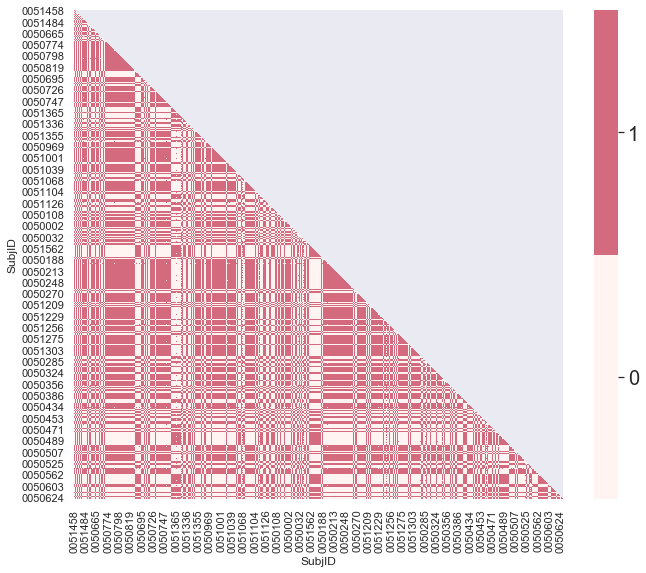

In [28]:
# Plot subject-pairs heatmap
m_col = 'membership_FS6.0'
c_membership = generate_pairwise_membership(member_df_concat,m_col)

# Generate a mask for the upper triangle
mask = np.zeros_like(c_membership, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(c_membership, mask=mask, cmap=cmap, square=True)
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])
    g.figure.axes[-1].tick_params(labelsize=20)

### Compare ML performance 

In [9]:
# Start time
start = time.time()

ml_results_dir = results_dir + 'ml/'

save_perf = False
rank_features = False
compute_null = False #Either False or number of permutations 

model_type = 'regression'
cv_type = 'shuffle_split'
group_col = False

ml_perf_concat = pd.DataFrame()
feature_rank_df_concat = pd.DataFrame()

for qc in qc_list[0:1]:
    master_df = master_df_dict[qc]
    roi_cols = common_roi_cols

    if model_type.lower() == 'regression':
        for dx_grp in [0]: #[0,1]:
            print('\nUsing qc {}, and Dx {}'.format(qc,dx_grp))
            ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
            outcome_col = 'AGE_AT_SCAN'            
            covar_continuous_cols = []
            covar_cat_cols = ['SEX','SITE_ID'] 
            model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
            ml_perf,perf_pval_dict,feature_rank_df,_ = computeSoftwareMLModels(ml_master_df,data_label,roi_cols,covar_continuous_cols,
                                                                             covar_cat_cols,outcome_col,group_col,model_type,model,
                                                                             rank_features,compute_null,n_jobs=-1)

            ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
            ml_perf['qc'] = np.tile(qc,len(ml_perf))
            ml_perf_concat = ml_perf_concat.append(ml_perf)
            
            feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
            feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
            feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
    else: 
        print('\nUsing qc {}'.format(qc))
        ml_master_df = master_df

        outcome_col = 'DX_GROUP'
        covar_continuous_cols = ['AGE_AT_SCAN']
        covar_cat_cols = ['SEX','SITE_ID'] 
        #model = svm.SVC(kernel='linear')
        model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

        ml_perf,perf_pval_dict,feature_rank_df = computeSoftwareMLModels(ml_master_df,roi_cols,covar_continuous_cols,covar_cat_cols,
                                                                         outcome_col,group_col,model_type,model,n_jobs=-1)

        ml_perf['qc'] = np.tile(qc,len(ml_perf))
        ml_perf_concat = ml_perf_concat.append(ml_perf)
        
        feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
        feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
        feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
if save_perf:
    save_path = '{}Software_DKT_ml_feature_imp_{}_{}_{}.pkl'.format(ml_results_dir,outcome_col,model_type,cv_type)
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    save_df = feature_rank_df_concat[(feature_rank_df_concat['predictor'].isin(roi_cols))]
    save_df = save_df.rename(columns={'predictor':'roi'})
    save_df.to_pickle(save_path)
        
    
end = time.time()
print('Run duration:')
print((end - start)/60.0)


Using qc No_QC, and Dx 0
Running ML classifer on 5 software
software ANTs
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-36.133, sd:10.407
software CIVET
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-42.695, sd:10.711
software FS5.1
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-33.106, sd:10.984
software FS5.3
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_m

{}


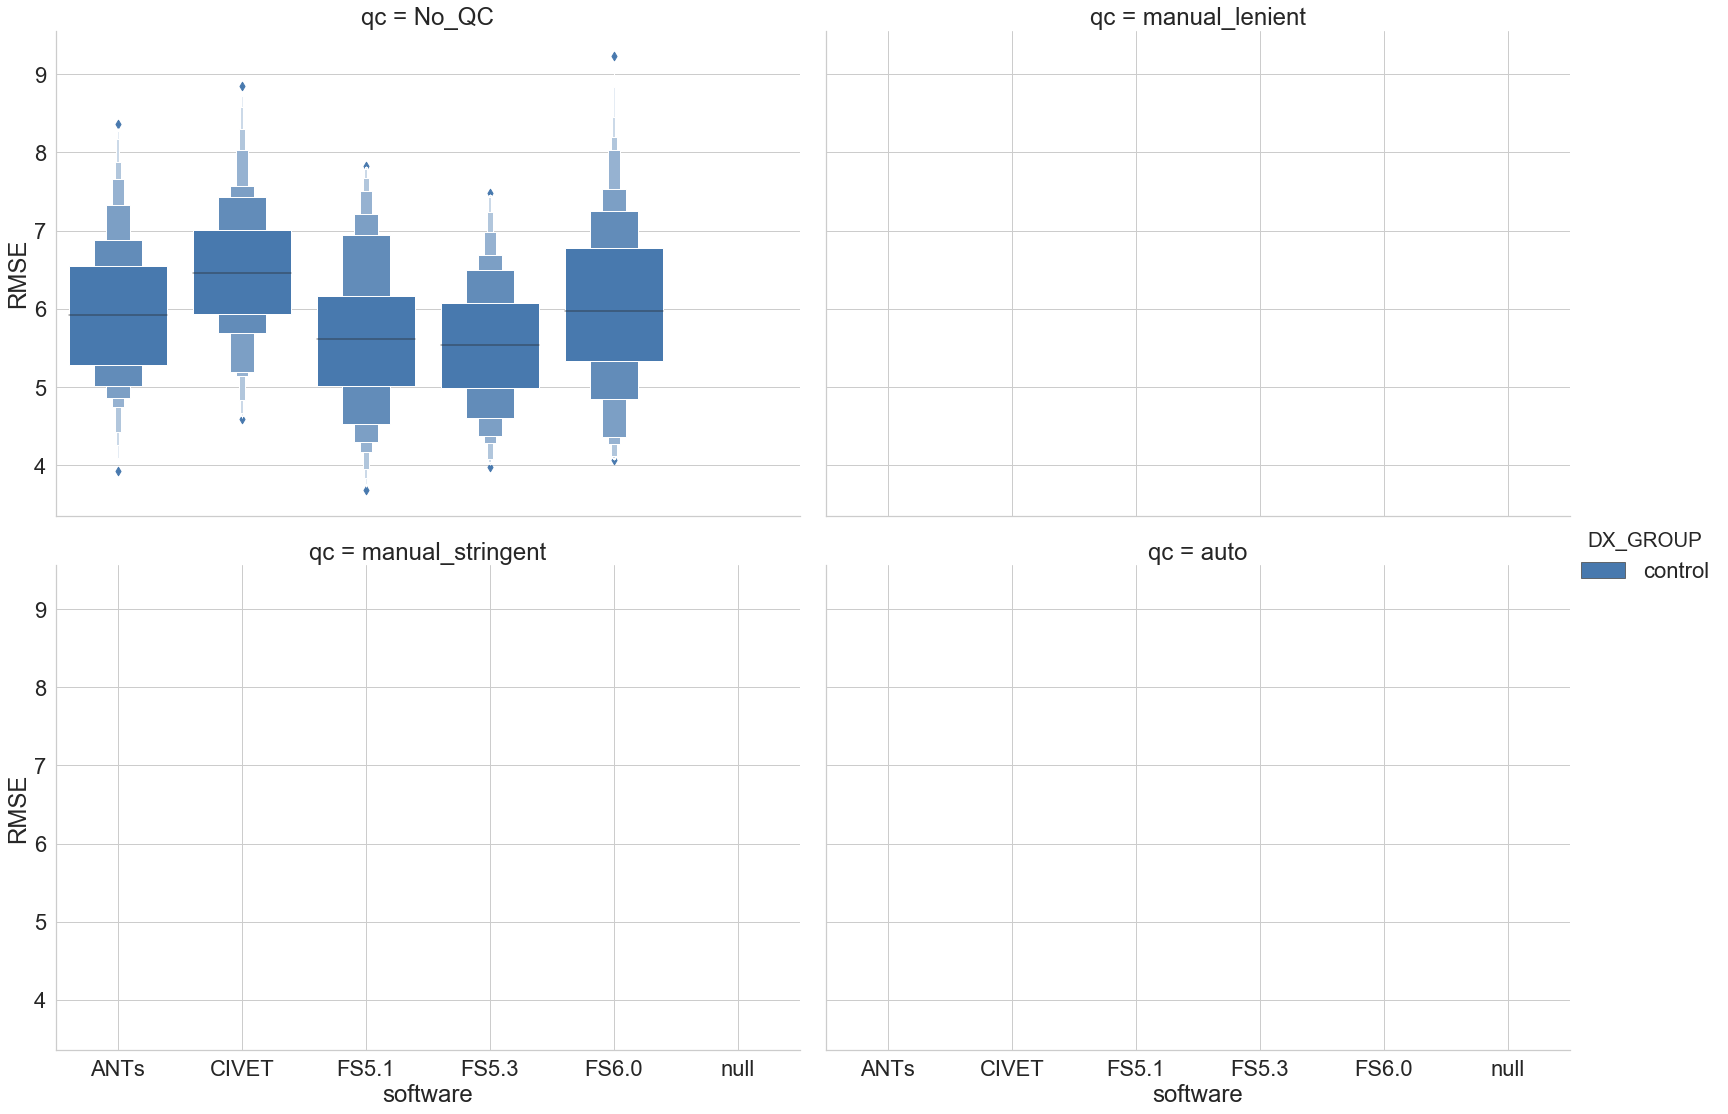

In [10]:
# plot ML performance
print(perf_pval_dict)
x_order = software_list + ['null']
col_order = qc_list 
colors = ["windows blue", "tomato", "greyish", "faded green", "dusty purple","dark grey"]
palette = sns.xkcd_palette(colors) #'Paired' #sns.xkcd_palette(colors)
sns.set(font_scale=2)
    
plot_df = ml_perf_concat.copy()

if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(-1*plot_df['neg_mean_squared_error'])
    plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    
    with sns.axes_style("whitegrid"): 
        g = sns.catplot(y='RMSE',x=data_label, hue='DX_GROUP', kind='boxen',col='qc',col_order=col_order,col_wrap=2,
                        order=x_order,palette=palette,height=8, aspect=1.4,legend=True,data=plot_df)
        #plt.legend(loc='upper right')
else:
    with sns.axes_style("white"): 
        g = sns.catplot(y='roc_auc',x=data_label, hue='DX_GROUP', kind='boxen',data=plot_df,col='qc',col_order=col_order,
                        order=x_order,palette=palette,height=20, aspect=1.1,legend=False)
#         plt.legend(loc='upper right')

### BrainAge type analysis
- Training models on controls and testing on ASDs

In [15]:
model_type = 'regression'
cv_type = 'shuffle_split'
group_col = 'DX_GROUP'

ml_perf_concat = pd.DataFrame()
feature_rank_df_concat = pd.DataFrame()
rank_features = False
compute_null = False

external_scores_concat_df = pd.DataFrame()
for qc in qc_list:
    master_df = master_df_dict[qc]
    master_df['DX_GROUP'] = master_df['DX_GROUP'].replace({0:'internal', 1:'external'})
    roi_cols = common_roi_cols

    print('\nUsing qc {}'.format(qc))
    ml_master_df = master_df
    outcome_col = 'AGE_AT_SCAN'
    covar_continuous_cols = []
    covar_cat_cols = ['SEX','SITE_ID'] 
    model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
    ml_perf,perf_pval_dict,feature_rank_df,external_scores = computeSoftwareMLModels(ml_master_df,data_label,roi_cols,covar_continuous_cols,
                                                                     covar_cat_cols,outcome_col,group_col,model_type,model,
                                                                     rank_features,compute_null,n_jobs=-1)
    external_scores['qc'] = np.tile(qc,len(external_scores))  
    external_scores_concat_df = external_scores_concat_df.append(external_scores)
    
    


Using qc No_QC
Running ML classifer on 5 software
software ANTs
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-42.711, sd:9.252
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
software CIVET
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-45.581, sd:11.783
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (778, 81), y 778 (18.09m, 8.23sd)
Using regression model with perf metric neg_mean_squared_error
software FS5.1
Using ['SEX', 'SITE_ID'] categorical c

software FS5.3
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-16.422, sd:2.984
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error
software FS6.0
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-17.495, sd:3.359
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (683, 80), y 683 (16.07m, 5.30sd)
Using regression model with perf metric neg_mean_squared_error


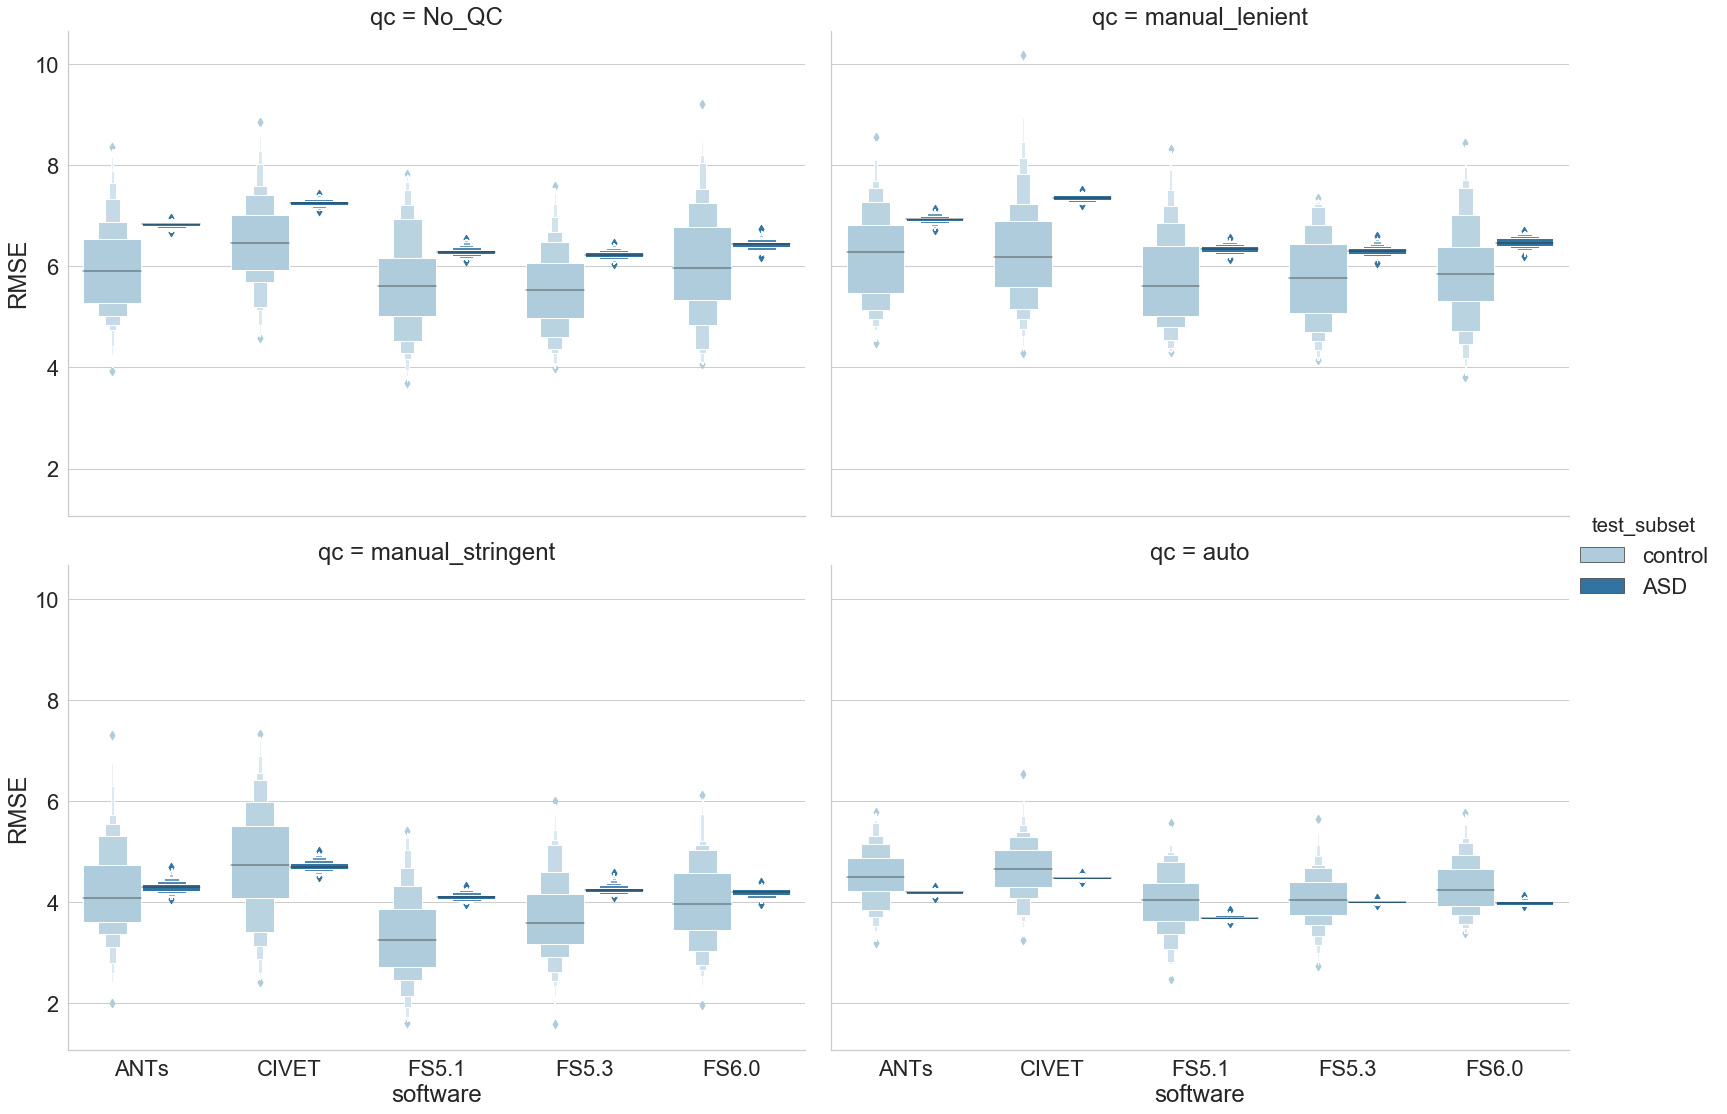

In [16]:
plot_df = external_scores_concat_df.copy()
col_order = qc_list 
x_order = software_list 

palette = 'Paired'
sns.set(font_scale=2)

if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(plot_df['neg_mean_squared_error'])
    plot_df['test_subset'] = plot_df['test_subset'].replace({'internal':'control', 'external':'ASD'})
    
    with sns.axes_style("whitegrid"): 
        g = sns.catplot(y='RMSE',x=data_label, hue='test_subset', kind='boxen',col='qc',col_order=col_order,col_wrap=2,
                        order=x_order,palette=palette,height=8, aspect=1.4,legend=True,data=plot_df)
    

### Get ML based feature importance
- verfied rerunning stability. For a sprcified random_state in CV, RFECV returns identical output.

In [137]:
feature_count_df = pd.DataFrame(columns=['count',data_label,'DX_GROUP','qc'])
i = 0
roi_cols = common_roi_cols
for pipe in ml_master_df[data_label].unique():
    for qc in feature_rank_df_concat['qc'].unique():
        for dx in [0,1]:
            n_feat = len(feature_rank_df_concat[(feature_rank_df_concat[data_label] == pipe) &                              
                                                (feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)])
            feature_count_df.loc[i] = [n_feat,pipe,dx,qc]
            i+=1
            print('Pipeline {}, n_roi {}, qc {}, dx {}, n_feat {}\n'.format(pipe,len(roi_cols),qc,dx,n_feat))

Pipeline FS5.3, n_roi 62, qc No_QC, dx 0, n_feat 5

Pipeline FS5.3, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline FS5.1, n_roi 62, qc No_QC, dx 0, n_feat 11

Pipeline FS5.1, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline ANTs, n_roi 62, qc No_QC, dx 0, n_feat 13

Pipeline ANTs, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline CIVET, n_roi 62, qc No_QC, dx 0, n_feat 18

Pipeline CIVET, n_roi 62, qc No_QC, dx 1, n_feat 0

Pipeline FS6.0, n_roi 62, qc No_QC, dx 0, n_feat 19

Pipeline FS6.0, n_roi 62, qc No_QC, dx 1, n_feat 0



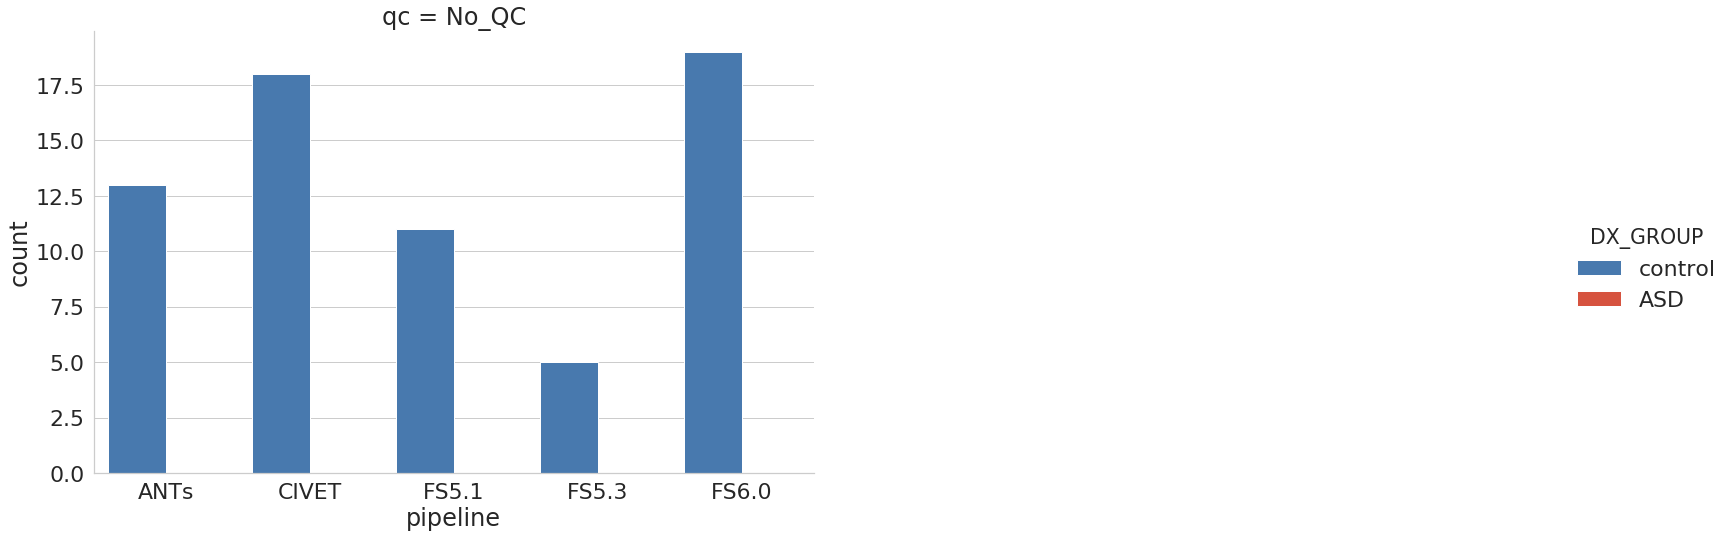

In [138]:
plot_df = feature_count_df
plot_df = plot_df #[plot_df['qc']=='No_QC']
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
sns.set(font_scale=2)

with sns.axes_style("whitegrid"): 
    x_order = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0']
    g = sns.catplot(y='count',x=data_label,hue='DX_GROUP', col='qc', col_wrap=2,
                    kind='bar', palette=palette, height=8, aspect=1.4, data=plot_df, order=x_order)

In [82]:
feature_rank_df_concat[(feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)]

,predictor,rank,grid_scores,pipeline,DX_GROUP,qc
0,L_lingual,1,-50.660181,FS6.0,1,No_QC
2,L_precuneus,1,-44.171878,FS6.0,1,No_QC
4,R_superiortemporal,1,-40.987022,FS6.0,1,No_QC
6,R_insula,1,-40.380302,FS6.0,1,No_QC
8,R_posteriorcingulate,1,-39.509839,FS6.0,1,No_QC
10,L_superiorfrontal,1,-38.761322,FS6.0,1,No_QC
14,R_precuneus,1,-38.550894,FS6.0,1,No_QC
16,R_isthmuscingulate,1,-38.430930,FS6.0,1,No_QC
22,L_posteriorcingulate,1,-38.542823,FS6.0,1,No_QC
27,R_lingual,1,-38.530277,FS6.0,1,No_QC



### Compare statsmodels performance 
- statmodels performance plots are generate using "generate_plots" notebook

In [58]:
save_sm_perf = False
sm_results_dir = results_dir + 'sm/'

model_type = 'ols'
if model_type == 'ols':
    covar_cols = [('DX_GROUP','cat'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('roi','continuous')
    signific_col = ('AGE_AT_SCAN','continuous')
    stat_model = 'ols' 
elif model_type == 'logit':
    covar_cols = [('AGE_AT_SCAN','continuous'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('DX_GROUP','cat') 
    signific_col = ('roi','continuous') 
    stat_model = 'logit' 
else:
    print('unknown stat model')

roi_cols = common_roi_cols

for qc in qc_list:
    print('QC type {}'.format(qc))
    master_df = master_df_dict[qc]
    sm_perf = computeSoftwareStatsModels(master_df,data_label,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    filtered_subs = master_df[subject_ID_col].unique()
    if save_sm_perf:
        save_path = '{}Software_DKT_sm_perf_{}_{}_{}_QC_{}_N_{}.pkl'.format(sm_results_dir,outcome_col[0],signific_col[0],
                                                                         stat_model,qc,len(filtered_subs))
        print('Saving sm_perf dictionary at \n{}'.format(save_path))
        sm_perf.to_pickle(save_path)


QC type No_QC
Running 62 mass-univariate ols statsmodels on 5 software
software ANTs
Example statsmodel run:
 R_inferiorparietal ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                      roi      coef      t_val         p_val    p_val_corr  \
22           L_precuneus -0.023962 -17.359359  4.462826e-57  2.766952e-55   
1            R_precuneus -0.021202 -15.693155  2.922874e-48  9.060909e-47   
24    L_inferiorparietal -0.023072 -14.220925  7.540301e-41  1.558329e-39   
40    R_isthmuscingulate -0.022793 -13.978348  1.147260e-39  1.778254e-38   
8     L_isthmuscingulate -0.022342 -13.685718  2.951937e-38  3.660402e-37   
61    R_inferiorparietal -0.023574 -13.559879  1.178163e-37  1.217435e-36   
60  L_posteriorcingulate -0.022629 -13.290321  2.226116e-36  1.971703e-35   
56         L_paracentral -0.015865 -13.117526  1.437094e-35  1.113748e-34   
20         R_paracentral -0.013759 -11.612746  8.328390e-29  5.737336e-28   
29  R_posteriorcingula

Example statsmodel run:
 R_inferiorparietal ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef      t_val         p_val    p_val_corr  \
1              R_precuneus -0.017548 -18.388548  2.657822e-62  1.647850e-60   
22             L_precuneus -0.017893 -18.008202  3.132594e-60  9.711040e-59   
61      R_inferiorparietal -0.017036 -16.798710  9.306111e-54  1.923263e-52   
24      L_inferiorparietal -0.017825 -16.591658  1.142378e-52  1.770686e-51   
39       L_superiorfrontal -0.017556 -16.079452  5.317309e-50  6.593463e-49   
52  L_lateralorbitofrontal -0.018287 -15.455525  8.353956e-47  8.632421e-46   
0   R_rostralmiddlefrontal -0.016803 -15.332909  3.489059e-46  3.090310e-45   
11      R_superiorparietal -0.014917 -15.208715  1.475619e-45  1.107873e-44   
48       R_superiorfrontal -0.017234 -15.201288  1.608203e-45  1.107873e-44   
23      L_superiorparietal -0.014538 -15.034897  1.099264e-44  6.815440e-44   

   soft

Example statsmodel run:
 R_inferiorparietal ~ AGE_AT_SCAN + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef     t_val         p_val    p_val_corr  \
0   R_rostralmiddlefrontal -0.021493 -7.876767  3.004968e-13  1.863080e-11   
9   L_rostralmiddlefrontal -0.020459 -7.423307  4.313112e-12  1.023779e-10   
1              R_precuneus -0.015678 -7.399367  4.953770e-12  1.023779e-10   
52  L_lateralorbitofrontal -0.019050 -7.191811  1.630178e-11  2.526776e-10   
48       R_superiorfrontal -0.018589 -7.084355  2.999461e-11  3.719332e-10   
39       L_superiorfrontal -0.017704 -6.664095  3.103611e-10  3.207065e-09   
23      L_superiorparietal -0.014307 -6.483013  8.286094e-10  7.339112e-09   
13         L_supramarginal -0.014710 -6.305283  2.139276e-09  1.657939e-08   
30              L_fusiform -0.014815 -6.234684  3.104580e-09  1.947771e-08   
24      L_inferiorparietal -0.015188 -6.232431  3.141566e-09  1.947771e-08   

   software  
0   